# Implement of a Gaussian curvature, mean curvature

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

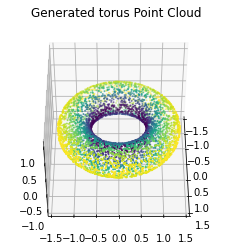

In [2]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    x_c = R * np.cos(theta)
    y_c = R * np.sin(theta)
    z_c = np.zeros(x.shape)
    
    K = np.cos(phi)/(r * (R + r * np.cos(phi))) 
    H = (R + 2* r * np.cos(phi))/ (2 * r * (R + r * np.cos(phi)))
    
    

    return np.column_stack((x, y, z)), np.column_stack((x_c, y_c, z_c)), K, H

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a torus point cloud with 1000 points and radius 1
torus, torus_centers, torus_K, torus_H = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

torus += np.random.normal(0, 0.0, torus.shape)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=1, c = torus_K)
#ax.scatter(torus[0, 0], torus[0, 1], torus[0, 2], s=10, c = 'r')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated torus Point Cloud")
ax.view_init(45, 0)
plt.show()


In [3]:
def find_basis(point_cloud, x,  extrin_dim = 3, epsilon_PCA = 0.1, tau_radius = 0.4):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    
    return tau_nbrs[1:], tau_dist[0][1:], O
   
    
        
    

In [4]:
cloud = torus
idx = 1998
query = cloud[idx].reshape(1, -1)

In [8]:
tau_nbrs, tau_dist, O = find_basis(cloud, query,  epsilon_PCA = 0.2, tau_radius = 1)

In [9]:
tau_nbrs.shape

(1293, 3)

In [10]:
tau_dist.shape

(1293,)

In [5]:
def compute_Gaussian_curvature(point_cloud, query_point, extrin_dim = 3, 
                               epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10, use_cross = True):
    
    tau_nbrs, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                             epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
            
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]

    ti = tau_nbrs[1:] - tau_nbrs[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

    if max_min_num < 1:
        min_quantile = max_min_num
        max_cur = np.quantile(tensor_all, 1-min_quantile)
        min_cur = np.quantile(tensor_all, min_quantile)
    else:
        max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num    
        min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return max_cur * min_cur
 

In [20]:
def compute_Gaussian_curvature(point_cloud, query_point, extrin_dim = 3, 
                               epsilon_PCA = 0.1, tau_radius = 0.4, prpl_percent = 0.5, use_cross = True):
    
    tau_nbrs, tau_dist, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                                       epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
 
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]

    ti = tau_nbrs - query_point[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms
    
    
    max_min_num = int(prpl_percent * len(tau_nbrs))
    #max_min_num = 250
    
    max_indices = np.argsort(tensor_all)[-max_min_num: ]
    max_cur = tensor_all[max_indices]
    
    min_indices = np.argsort(tensor_all)[:max_min_num]
    min_cur = tensor_all[min_indices]
    
    max_cur_weight = np.sqrt(np.exp(-0.01 * np.array(tau_dist[max_indices]) ** 2 / np.sqrt(tau_radius)))
    min_cur_weight = np.sqrt(np.exp(-0.01 * np.array(tau_dist[min_indices]) ** 2 / np.sqrt(tau_radius)))
    
    principal_cur1 = sum(max_cur_weight * max_cur)/sum(max_cur_weight)
    principal_cur2 = sum(min_cur_weight * min_cur)/sum(min_cur_weight)
    #principal_cur1 = sum(max_cur)/len(max_cur)
    #principal_cur2 = sum(min_cur)/len(min_cur)
    
    return principal_cur1 * principal_cur2 

## Gaussian curvature 

In [18]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(torus, torus[i].reshape(1, -1), 
                                   epsilon_PCA =0.3, tau_radius = 0.6, prpl_percent = 0.2)
    curvature.append(b)

100%|██████████| 5000/5000 [00:14<00:00, 344.98it/s]


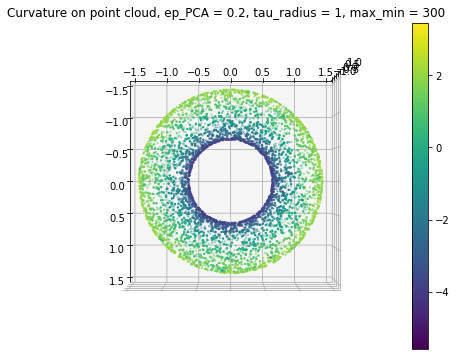

In [19]:
v = np.array(curvature).T
# Visualize the point cloud

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 300")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [83]:
corr, _ = pearsonr(torus_K , v)
corr

0.9916052821265208

In [84]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(torus_K, v))

0.4899192805451439

In [39]:
corr, _ = pearsonr(torus_K , v)
rmse = np.sqrt(mean_squared_error(torus_K, v))

stat = np.array([[rmse, corr]])

savetxt('stats_torus_noise0.csv', stat, delimiter=',')

In [34]:
from numpy import savetxt
savetxt('torus_noise0.csv', corr, delimiter=',')

## Mean curvature

In [41]:
def compute_mean_curvature(point_cloud, query_point, center, extrin_dim = 3,
                           epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10, use_cross = True):
    
    tau_nbrs, tau_dist, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                                       epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
    
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]
        
    if np.dot(query_point[0] - center, O2) < 0:
        O2 = -O2
    #max_min_num = int(0.4 * len(tau_nbrs))

    ti = tau_nbrs[1:] - tau_nbrs[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

    if max_min_num < 1:
        min_quantile = max_min_num
        max_cur = np.quantile(tensor_all, 1-min_quantile)
        min_cur = np.quantile(tensor_all, min_quantile)
    else:
        max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num    
        min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return (max_cur + min_cur)/2

In [105]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_mean_curvature(torus, torus[i].reshape(1, -1), torus_centers[i], 
                               epsilon_PCA =0.2, tau_radius = 1, max_min_num = 450)
    curvature.append(b)

100%|██████████| 5000/5000 [00:15<00:00, 315.39it/s]


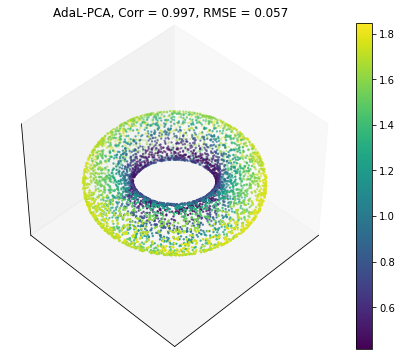

In [106]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = -v)
ax.set_title("AdaL-PCA, Corr = 0.997, RMSE = 0.057")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.colorbar(scatter)
ax.set_aspect('equal')
ax.view_init(45, 45)
plt.savefig("mc_torus.png", dpi = 300)
plt.show()

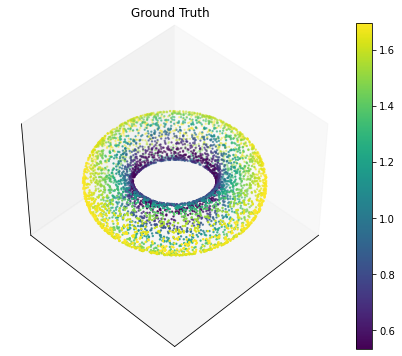

In [60]:
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = torus_H)
ax.set_title("Ground Truth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.colorbar(scatter)
ax.set_aspect('equal')
ax.view_init(45, 45)
plt.savefig("mc_torus_gt.png", dpi = 300)
plt.show()

In [61]:
corr, _ = pearsonr(torus_H , -v)
rmse = np.sqrt(mean_squared_error(torus_H, -v))
print((rmse, corr))

(0.05758973299422447, 0.997375496144158)


# On different dataset

In [62]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    H = a*b*c * (3*(a**2 + b**2) 
                 + 2*c**2 + (a**2 + b**2 - 2*c**2)* np.cos(2*phi)
                 - 2*(a**2 -b**2) * np.cos(2*theta)* np.sin(phi)**2) / (8*(a**2 * b**2 * np.cos(phi)**2 + 
                                                                          c**2 * (b**2 * np.cos(theta)**2
                                                                                 +a**2 * np.sin(theta)**2)
                                                                          * np.sin(phi)**2) **1.5)
    return np.column_stack((rx, ry, rz)), H

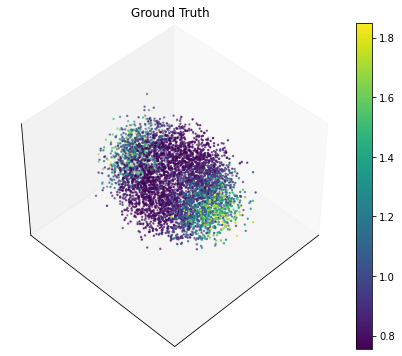

In [269]:
ell, e_H = generate_ellipsoid_cloud(0.9, 1.5, 0.9)
ell += np.random.normal(0, 0.3, ell.shape)
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ell[:num_eval, 0], ell[:num_eval, 1], ell[:num_eval, 2], s=2, c = e_H)
ax.set_title("Ground Truth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.colorbar(scatter)
ax.set_aspect('equal')
ax.view_init(45, 45)
#plt.savefig("mc_ell_gt.png", dpi = 300)
plt.show()


In [280]:
num_eval = int(len(ell))
ell_centers = np.array([0, 0, 0])
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_mean_curvature(ell, ell[i].reshape(1, -1), ell_centers, 
                               epsilon_PCA =1, tau_radius = 2, max_min_num = 2000)
    curvature.append(b)

100%|██████████| 5000/5000 [00:32<00:00, 154.52it/s]


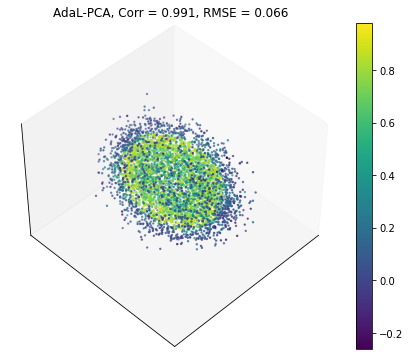

In [281]:
v = np.array(curvature).T
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ell[:num_eval, 0], ell[:num_eval, 1], ell[:num_eval, 2], s=2, c = -v)
ax.set_title("AdaL-PCA, Corr = 0.991, RMSE = 0.066")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.colorbar(scatter)
ax.set_aspect('equal')
ax.view_init(45, 45)
plt.savefig("mc_ell.png", dpi = 300)
plt.show()

In [282]:
corr, _ = pearsonr(e_H , -v)
rmse = np.sqrt(mean_squared_error(e_H, -v))
print((rmse, corr))

(0.6794659770305412, -0.10534958821553878)


In [273]:
corr, _ = pearsonr(e_H , -v)
rmse = np.sqrt(mean_squared_error(e_H, -v))
print((rmse, corr))

(0.7078805932548432, -0.10848906469015562)


In [187]:
def generate_hyperboloid_cloud(a, b, c, num_points=5000, seed=42):
    np.random.seed(seed)

    u = np.random.uniform(-1.5,1.5,num_points)
    v = np.random.uniform(0, 2*np.pi, num_points)

    x = a*np.sqrt(1 + np.square(u)) * np.cos(v)
    y = b*np.sqrt(1 + np.square(u)) * np.sin(v)
    z = c*u

    K = - c**2 / np.square(c**2 + (a**2 + c**2) * np.square(u))
    H = (c**3 * np.cosh(u) **2 + a**2 * c* np.sinh(u)**2 
         - a**2 * c)/(a* (a**2 *np.sinh(u)**2 + c**2 * np.cosh(u)**2)**1.5)
    return np.column_stack((x, y, z)), K, H

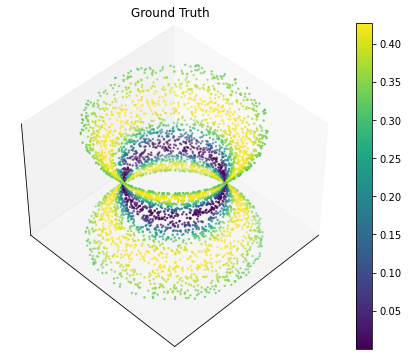

In [199]:
hp, hp_K, hp_H = generate_hyperboloid_cloud(0.9, 0.9, 0.9)

# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(hp[:num_eval, 0], hp[:num_eval, 1], hp[:num_eval, 2], s=2, c = hp_H)
ax.set_title("Ground Truth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.colorbar(scatter)
ax.set_aspect('equal')
ax.view_init(45, 45)
plt.savefig("mc_hp_gt.png", dpi = 300)
plt.show()

In [246]:
num_eval = int(len(ell))
hp_centers = np.array([0, 0, 0])
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_mean_curvature(hp, hp[i].reshape(1, -1), hp_centers, 
                               epsilon_PCA =0.4, tau_radius = 0.8, max_min_num = 130)
    curvature.append(b)

100%|██████████| 5000/5000 [00:12<00:00, 416.43it/s]


In [249]:
dd = np.clip(-v, a_max=None, a_min=0)

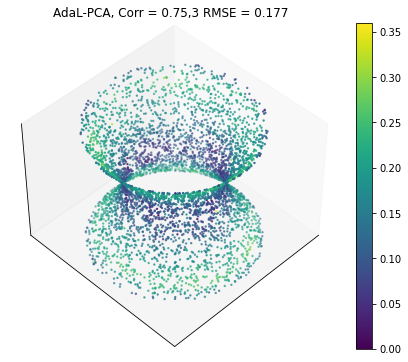

In [251]:
v = np.array(curvature).T
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(hp[:num_eval, 0], hp[:num_eval, 1], hp[:num_eval, 2], s=2, c = dd)
ax.set_title("AdaL-PCA, Corr = 0.75,3 RMSE = 0.177")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.colorbar(scatter)
ax.set_aspect('equal')
ax.view_init(45, 45)
plt.savefig("mc_hp.png", dpi = 300)
plt.show()

In [248]:
corr, _ = pearsonr(hp_H , -v)
rmse = np.sqrt(mean_squared_error(hp_H, -v))
print((rmse, corr))

(0.17739588191430827, 0.7530735764516158)


## Gaussian curvature

In [57]:
num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), 
                                   epsilon_PCA =0.2, tau_radius = 1, max_min_num = 250)
    curvature.append(b)

100%|██████████| 5000/5000 [00:12<00:00, 414.18it/s]


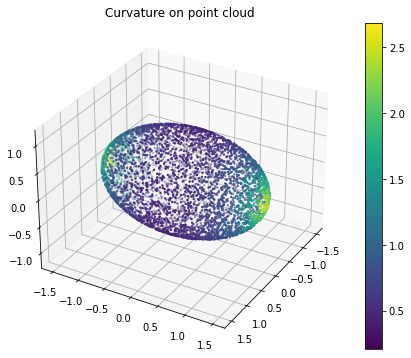

In [64]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud")
ax.view_init(30, 30)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [59]:
def ellipsoid_ground_truth(point_cloud, a, b, c):
    #point_cloud: N by 3 array
    cur = []
    for p in point_cloud:
        k = 1 / (a **2 * b**2 * c**2 * (p[0]**2 / a**4 + p[1]**2 / b**4 + p[2]**2 / c**4) **2)
        cur.append(k)
    return cur

In [60]:
dd= np.array(ellipsoid_ground_truth(ellipsoid, 0.9, 1.5, 0.9))

In [62]:
from scipy.stats import pearsonr
corr, _ = pearsonr(dd, v)
corr

0.9922284424884587

## Mean curvature

In [41]:
ellipsoid_center = np.array([0, 0, 0])

num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_mean_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), ellipsoid_center,
                                    epsilon_PCA =0.2, tau_radius = 1, max_min_num = 200)
    curvature.append(b)

100%|██████████| 5000/5000 [00:11<00:00, 417.47it/s]


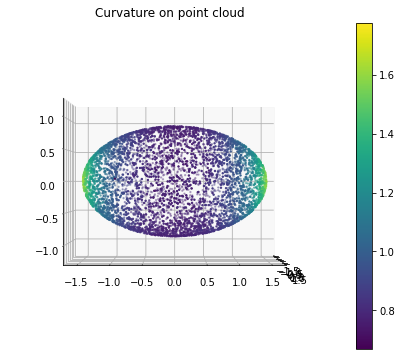

In [42]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud")
ax.view_init(0, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()